<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

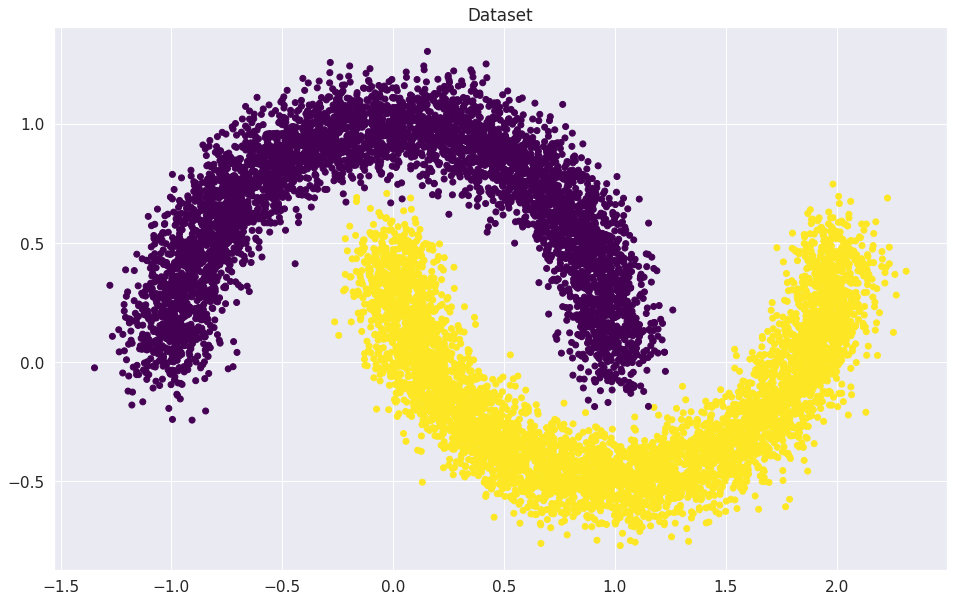

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.from_numpy(X_train).float()
y_train_t =  torch.from_numpy(y_train).float()
X_val_t =  torch.from_numpy(X_val).float()
y_val_t =  torch.from_numpy(y_val).float()

In [6]:
X_train_t

tensor([[ 0.5020, -0.3376],
        [-0.0200,  0.2391],
        [ 0.5703,  0.8117],
        ...,
        [ 0.3216, -0.3567],
        [ 2.0134,  0.0323],
        [ 0.1791,  0.9310]])

Создаем `Dataset` и `DataLoader`. 

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features,out_features ))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features ))

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [9]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [10]:
#YOUR CODE
wieght_count = linear_regression.weights.reshape(-1).size()[0]
bias_count = linear_regression.bias_term.reshape(-1).size()[0]
print("колличество весов {},\nколличество свободных членов {},\nобщеколичество переменных {}".format(wieght_count ,bias_count,wieght_count + bias_count))

print("колличество весов по батчам {},\nколличество свободных членов по батчам {},\nобщеколичество переменных по батчам {}".format(wieght_count * 128 ,bias_count * 128,(wieght_count + bias_count) * 128 ))


колличество весов 2,
колличество свободных членов 1,
общеколичество переменных 3
колличество весов по батчам 256,
колличество свободных членов по батчам 128,
общеколичество переменных по батчам 384


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression.forward(X_batch)
        loss =  loss_function(outp.reshape(-1), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.exp(outp) / torch.exp(outp).sum(dim=1, keepdims=True)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.546875
Iteration: 200
Batch accuracy: 0.4609375
Iteration: 300
Batch accuracy: 0.578125
Iteration: 400
Batch accuracy: 0.4765625
Iteration: 500
Batch accuracy: 0.4921875
Iteration: 600
Batch accuracy: 0.40625
Iteration: 700
Batch accuracy: 0.515625
Iteration: 800
Batch accuracy: 0.53125
Iteration: 900
Batch accuracy: 0.5390625

Iteration: 936.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** сошлось за 755 итераций

### Визуализируем результаты

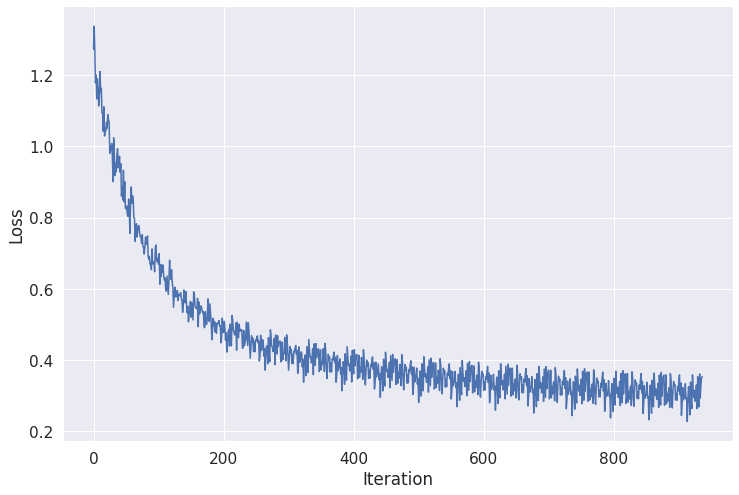

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

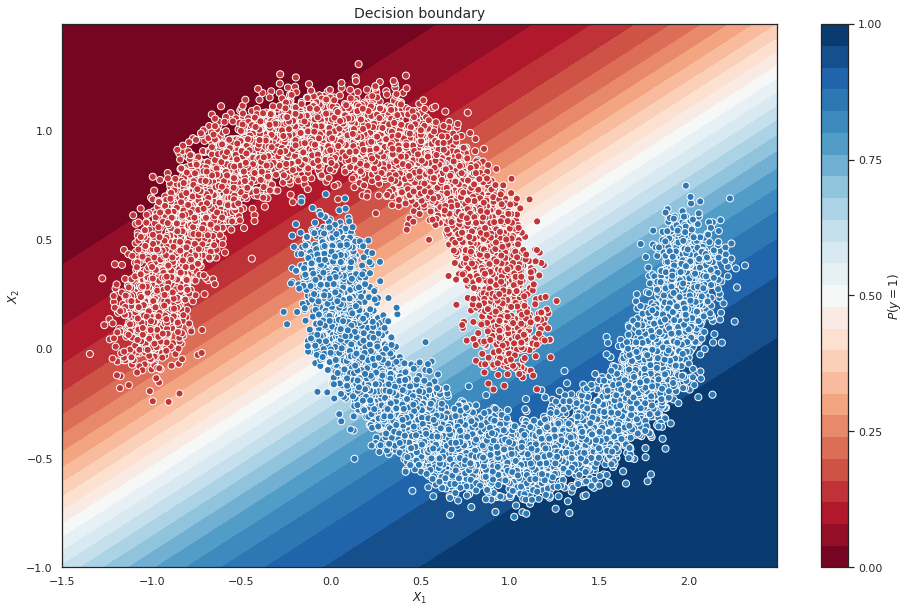

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp =  model.forward(X_batch)
        probabilities =  torch.exp(outp) / torch.exp(outp).sum(dim=1, keepdims=True)
        preds = (probabilities > 0.5).type(torch.long) 
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [15]:
from sklearn.metrics import accuracy_score
result = predict(val_dataloader,linear_regression )

print("итоговый скор {}".format(accuracy_score(y_val,result[:2500])))
# YOUR CODE. Compute total accuracy

итоговый скор 0.4912


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.4912

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [16]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])
batch_size = 128
# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_dataloader =  DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [17]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 Задание. Простая полносвязная нейронная сеть  нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [18]:
activation = Identical()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
)


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [21]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train() 
              optimizer.zero_grad() 
              outp = model(x_batch)
            else:
              model.eval() 
              with torch.no_grad(): 
                outp = model(x_batch) 
              
            preds = outp.argmax(-1)
            correct =  torch.sum(preds == y_batch)
            all =  preds.size()[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward() 
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8638822115384616
Loader: valid. Accuracy: 0.8891225961538461
Epoch: 2
Loader: train. Accuracy: 0.8958834134615384
Loader: valid. Accuracy: 0.8970352564102564
Epoch: 3
Loader: train. Accuracy: 0.9004740918803419
Loader: valid. Accuracy: 0.8971354166666666
Epoch: 4
Loader: train. Accuracy: 0.9022936698717948
Loader: valid. Accuracy: 0.8999399038461539
Epoch: 5
Loader: train. Accuracy: 0.904029780982906
Loader: valid. Accuracy: 0.9013421474358975
Epoch: 6
Loader: train. Accuracy: 0.9053318643162394
Loader: valid. Accuracy: 0.9013421474358975
Epoch: 7
Loader: train. Accuracy: 0.9065004006410257
Loader: valid. Accuracy: 0.901542467948718
Epoch: 8
Loader: train. Accuracy: 0.9078024839743589
Loader: valid. Accuracy: 0.9017427884615384
Epoch: 9
Loader: train. Accuracy: 0.9090377938034188
Loader: valid. Accuracy: 0.9030448717948718
Epoch: 10
Loader: train. Accuracy: 0.9098557692307693
Loader: valid. Accuracy: 0.905448717948718


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [22]:
elu_accuracy = accuracy["valid"]

In [23]:


def test_activation_function(activation):


  model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
  )
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  loaders = {"train": train_dataloader, "valid": valid_dataloader}

  max_epochs = 10
  accuracy = {"train": [], "valid": []}
  for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train() 
              optimizer.zero_grad() 
              outp = model(x_batch)
            else:
              model.eval() 
              with torch.no_grad(): 
                outp = model(x_batch) 
              
            preds = outp.argmax(-1)
            correct =  torch.sum(preds == y_batch)
            all =  preds.size()[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward() 
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
  return(accuracy["valid"])



In [24]:
plain_accuracy = test_activation_function(Identical())
relu_accuracy = test_activation_function(nn.ReLU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())

Epoch: 1
Loader: train. Accuracy: 0.8647168803418803
Loader: valid. Accuracy: 0.8912259615384616
Epoch: 2
Loader: train. Accuracy: 0.895950186965812
Loader: valid. Accuracy: 0.8981370192307693
Epoch: 3
Loader: train. Accuracy: 0.9001736111111112
Loader: valid. Accuracy: 0.897636217948718
Epoch: 4
Loader: train. Accuracy: 0.902877938034188
Loader: valid. Accuracy: 0.9000400641025641
Epoch: 5
Loader: train. Accuracy: 0.9044304220085471
Loader: valid. Accuracy: 0.9009415064102564
Epoch: 6
Loader: train. Accuracy: 0.9058159722222222
Loader: valid. Accuracy: 0.9008413461538461
Epoch: 7
Loader: train. Accuracy: 0.9067341079059829
Loader: valid. Accuracy: 0.9014423076923077
Epoch: 8
Loader: train. Accuracy: 0.9081697382478633
Loader: valid. Accuracy: 0.9017427884615384
Epoch: 9
Loader: train. Accuracy: 0.9094050480769231
Loader: valid. Accuracy: 0.90234375
Epoch: 10
Loader: train. Accuracy: 0.910423344017094
Loader: valid. Accuracy: 0.9028445512820513
Epoch: 1
Loader: train. Accuracy: 0.86570

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

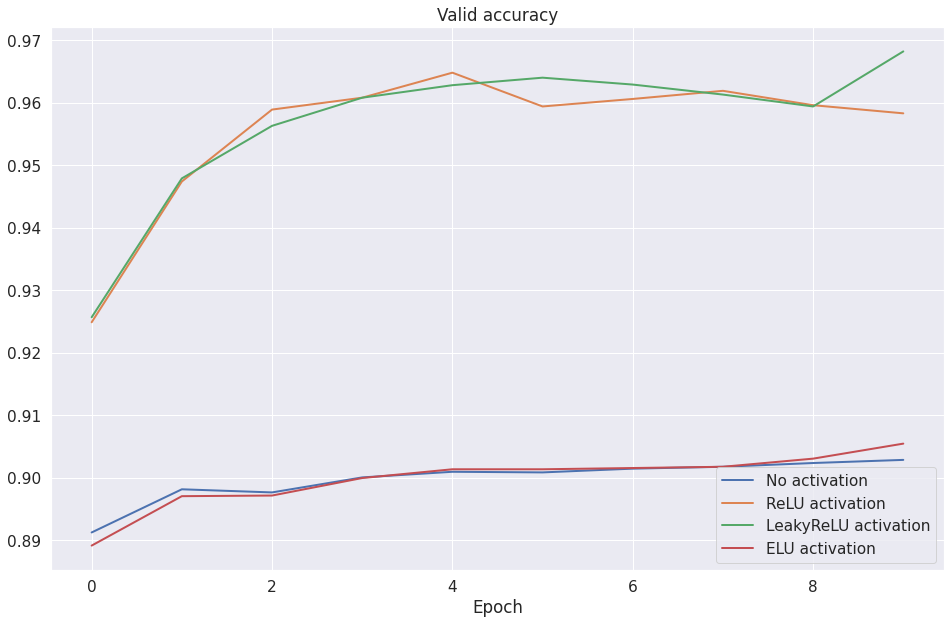

In [25]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

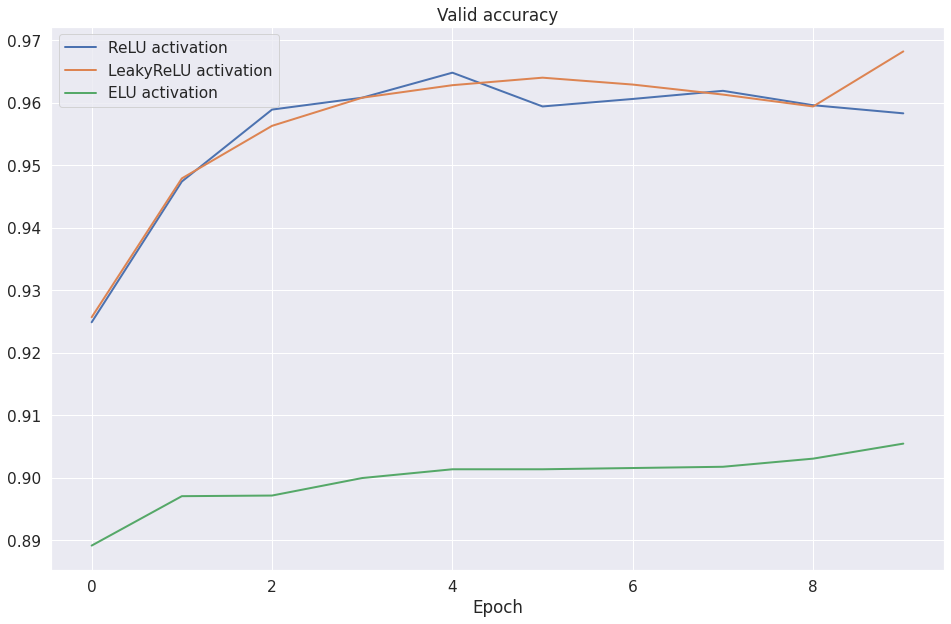

In [26]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [27]:
print(f"лучший скор на LeakyReLU activation  {leaky_relu_accuracy[-1]}")

лучший скор на LeakyReLU activation  0.9682491987179487


**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**лучший результат на LeakyReLU activation

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [28]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-10-27 15:03:23--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-10-27 15:03:24--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   261KB/s    in 0.2s    

2022-10-27 15:03:24 (261 KB/s) - ‘sample_photo.jpg’ saved [49337/4

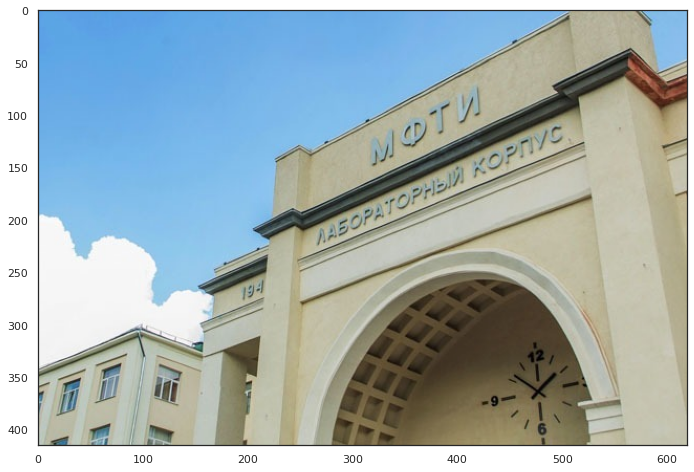

In [29]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [30]:
A = [[0, 0, 0],[0, 1, 0],[0, 0, 0]]
B = [[0, 1, 0],[0, -2, 0],[0, 1, 0]]
V = [[0, 0, 0],[1, -2, 1],[0, 0, 0]]
G = [[0, 1, 0],[1, -4, 1],[0, 1, 0]]
D = [[0, -1, 0],[-1, 5, -1],[0, -1, 0]]
E = [[0.0625, 0.125, 0.0625],[0.125, 0.25, 0.125],[0.0625, 0.125, 0.0625]]

kernels_list = [A,B,V,G,D,E]
kernels_name = ["А","Б","В","Г","Д","Е"]
for num, kernel in enumerate(kernels_list):
  print(num , kernel,kernels_name[num] )

0 [[0, 0, 0], [0, 1, 0], [0, 0, 0]] А
1 [[0, 1, 0], [0, -2, 0], [0, 1, 0]] Б
2 [[0, 0, 0], [1, -2, 1], [0, 0, 0]] В
3 [[0, 1, 0], [1, -4, 1], [0, 1, 0]] Г
4 [[0, -1, 0], [-1, 5, -1], [0, -1, 0]] Д
5 [[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]] Е


In [31]:
for num, kern in enumerate(kernels_list):
  kern = torch.from_numpy(np.array(kern))
  print(kern)

tensor([[0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]])
tensor([[ 0,  1,  0],
        [ 0, -2,  0],
        [ 0,  1,  0]])
tensor([[ 0,  0,  0],
        [ 1, -2,  1],
        [ 0,  0,  0]])
tensor([[ 0,  1,  0],
        [ 1, -4,  1],
        [ 0,  1,  0]])
tensor([[ 0, -1,  0],
        [-1,  5, -1],
        [ 0, -1,  0]])
tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], dtype=torch.float64)


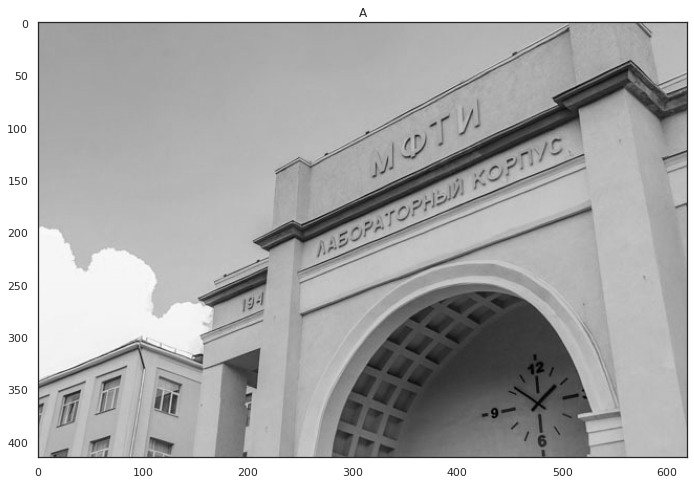

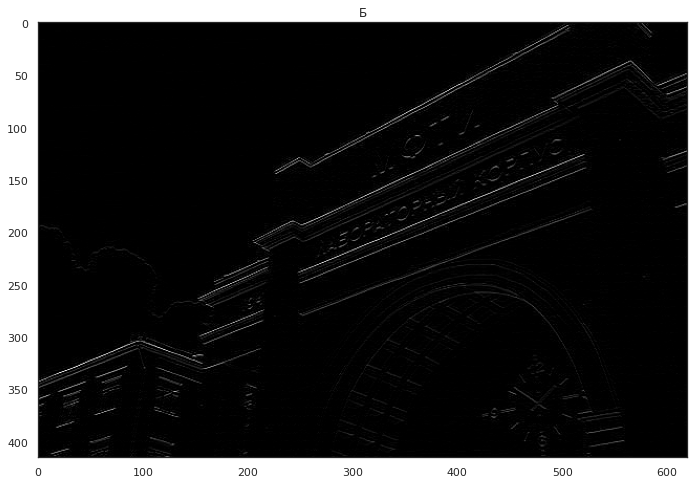

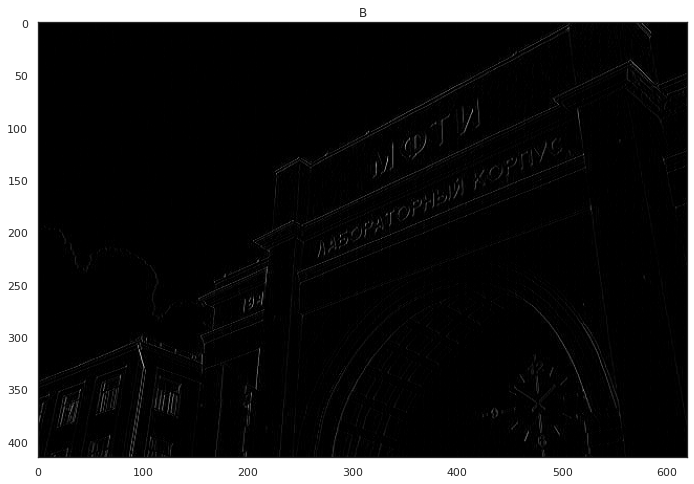

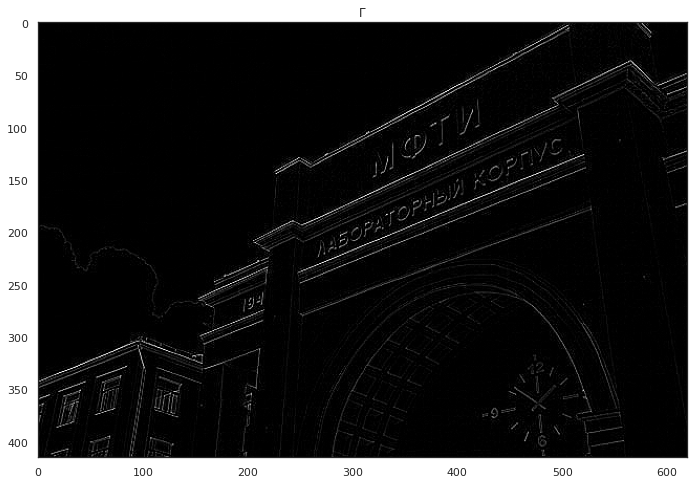

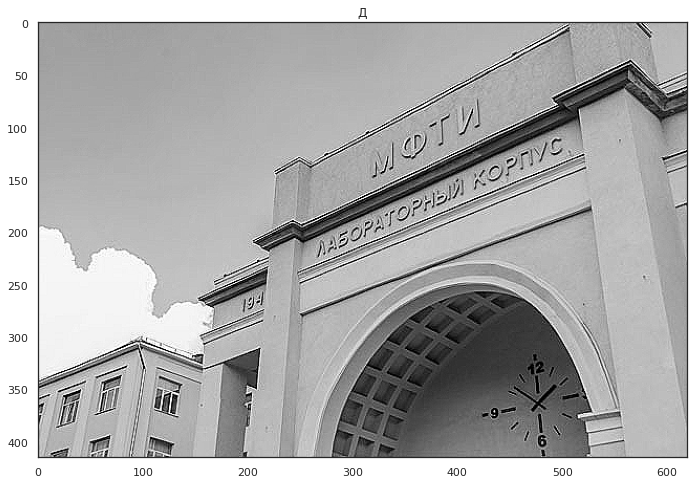

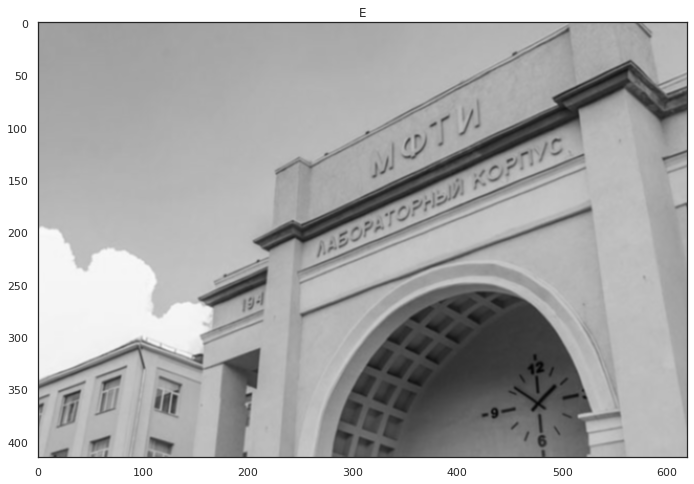

In [32]:
for num, kern in enumerate(kernels_list):
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    kernel = torch.tensor(kern).reshape(1, 1, 3, 3).type(torch.float32)

    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]  #

    plt.figure(figsize=(12, 8))
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3
    plt.title(kernels_name[num])
    plt.imshow(result_np)
    plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**
1 - Е
2 - Д 
3 - А
4 - В
5 - Б
6 - Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [33]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d((2,2))
        self.fc1 = nn.Linear( 5 * 5 * 16, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
  
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ...
        return x

In [34]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [35]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
              model.train() 
              optimizer.zero_grad() 
              outp = model(x_batch)
            else:
              model.eval() 
              with torch.no_grad(): 
                outp = model(x_batch) 
              
            preds = outp.argmax(-1)
            correct =  torch.sum(preds == y_batch)
            all =  preds.size()[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward() 
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8712106036324786
Loader: valid. Accuracy: 0.96484375
Epoch: 2
Loader: train. Accuracy: 0.9676983173076923
Loader: valid. Accuracy: 0.9733573717948718
Epoch: 3
Loader: train. Accuracy: 0.9775307158119658
Loader: valid. Accuracy: 0.9782652243589743
Epoch: 4
Loader: train. Accuracy: 0.9833400106837606
Loader: valid. Accuracy: 0.9815705128205128
Epoch: 5
Loader: train. Accuracy: 0.9865451388888888
Loader: valid. Accuracy: 0.983573717948718
Epoch: 6
Loader: train. Accuracy: 0.9890157585470085
Loader: valid. Accuracy: 0.9836738782051282
Epoch: 7
Loader: train. Accuracy: 0.9905682425213675
Loader: valid. Accuracy: 0.985176282051282
Epoch: 8
Loader: train. Accuracy: 0.9921040331196581
Loader: valid. Accuracy: 0.9844751602564102
Epoch: 9
Loader: train. Accuracy: 0.9931390224358975
Loader: valid. Accuracy: 0.985176282051282
Epoch: 10
Loader: train. Accuracy: 0.9939403044871795
Loader: valid. Accuracy: 0.9865785256410257


In [36]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

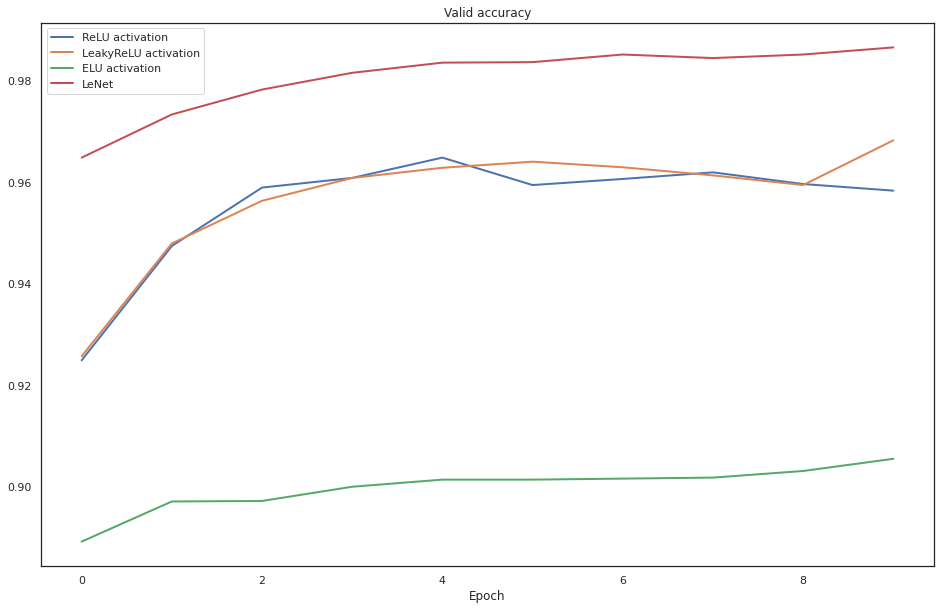

In [37]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [38]:
round(lenet_accuracy[-1],2)

0.99

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99 